In [1]:
import h5py
import numpy as np
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('classic')
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess

from scipy.interpolate import RectBivariateSpline, interp2d
from scipy.ndimage import map_coordinates

In [2]:
py_directory = "../"
py_directory += "output_travelling_vortex/"

def spatially_averaged_rmse(arr,ref):
    n,m = ref.shape
    N = n * m
    return np.sqrt(((arr - ref)**2).mean())

def get_filename(grid_x,grid_y,size,end_time,suffix):
    return "output_travelling_vortex_ensemble=" + str(size) + "_" + str(grid_x) + "_" + str(grid_y) + "_" + str(end_time) + suffix + ".h5"

def get_path(filename):
    return py_directory + filename

def py_out(pyfile,py_dataset,time):
    return pyfile[str(py_dataset)][str(py_dataset)+time][:]

def ensemble_test_case(time, path, N, attribute, label_type='TIME'):
    inner = (slice(2,-2),slice(2,-2))
    # inner = (slice(None,),slice(None,))
    file = h5py.File(path,'r')

    array = []
    for n in range(N):
        if label_type == 'TIME':
            t_label = '_ensemble_mem=%i_%.2f_after_full_step' %(n,time)
        elif label_type == 'STEP':
            t_label = '_%.3d_after_full_step' %(time)
            
        array.append(py_out(file,attribute,time=t_label)[inner])

    array = np.array(array)
    array = array.mean(axis=0)

    file.close()
    file.close()
    return array

def bin_func(obs,ens_mem_shape):
    obs = obs.reshape(ens_mem_shape[0],obs.shape[0]//ens_mem_shape[0],
                      ens_mem_shape[1],obs.shape[1]//ens_mem_shape[1])
    return obs.mean(axis=(1,3))

In [50]:
ref_grid_x = 32
ref_grid_y = 32
grid_x = 32
grid_y = 32
ref_size = 1
ens_size_1 = 10
ens_size_2 = 10
end_time = 1.0
print_output = True
ens_2 = True
# interpolation_method = "map_coordinates"
# interpolation_method = "interp2d"
# mode, order = 'wrap', 3

# inner = (slice(2,-2),slice(2,-2))
# inner = (slice(None,),slice(None,))

# times = np.arange(0,11) / 10
# times= [0.0,0.02,0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18,0.20]
# times = [0.0,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
# times = np.linspace(0.0,10.0,101)
# times = np.linspace(0.0,10.0,11*2-1)
# times = np.insert(times,1,0.40)
times = np.linspace(0,1.0,num=21)[::5]
# times = [0.0]
print(times)


attributes = ['rho', 'rhou', 'rhov', 'Y']
# attributes = ['rhoY']
fn_suffix = "_rho=1.4"

py_filename_ref = get_filename(ref_grid_x, ref_grid_y, ref_size, end_time, "_truth")
py_path_ref = get_path(py_filename_ref)

py_filename_ref_1 = get_filename(grid_x,grid_y,ref_size,end_time, "")
py_path_ref_1 = get_path(py_filename_ref_1)

py_filename_ens_1 = get_filename(grid_x,grid_y,ens_size_1,end_time, "")
py_path_ens_1 = get_path(py_filename_ens_1)
print(py_filename_ens_1)

if ens_2 == True:
    py_filename_ens_2 = get_filename(grid_x,grid_y,ens_size_2,end_time, "_noda")
    py_path_ens_2 = get_path(py_filename_ens_2)


for attribute in attributes:
    rmse_ref_1, rmse_ens_1, rmse_ens_2 = [], [], []
    cnt = 0
    for time in times:
        comp_ref = ensemble_test_case(time, py_path_ref,ref_size, attribute)
        # print(comp_ref.shape)
        # comp_ref_inner = comp_ref[inner]
        comp_ref_1 = ensemble_test_case(time, py_path_ref_1,ref_size, attribute)
        # print(comp_ref_1.shape)
        # comp_ref_1_inner = comp_ref_1[inner]
        comp_ref = bin_func(comp_ref, comp_ref_1.shape)
        
        # if interpolation_method == "map_coordinates":
        #     x = np.linspace(0,comp_ref_1.shape[0],comp_ref.shape[0])
        #     y = np.linspace(0,comp_ref_1.shape[1],comp_ref.shape[1])

        #     # x = np.linspace(0,comp_ref_1.shape[0]-1,comp_ref.shape[0])
        #     # a = -1
        #     # b = -1
        #     # x = np.arange(comp_ref.shape[0]) / (comp_ref.shape[0] + a) * (comp_ref_1.shape[0] + b)
        #     # y = np.arange(comp_ref.shape[1]) / (comp_ref.shape[1] + a) * (comp_ref_1.shape[1] + b)
        #     # y = np.linspace(0,comp_ref_1.shape[0]-2,comp_ref.shape[1])

        #     x,y = np.meshgrid(x,y)
        #     comp_ref_1 = map_coordinates(comp_ref_1,[y,x],mode=mode,order=order)

        # if interpolation_method == "interp2d":
        #     x = np.linspace(-0.5,0.5,comp_ref_1.shape[0])
        #     y = np.linspace(-0.5,0.5,comp_ref_1.shape[1])

        #     x0 = np.linspace(-0.5,0.5,comp_ref.shape[0])
        #     y0 = np.linspace(-0.5,0.5,comp_ref.shape[1])
        #     mesh = np.array(np.meshgrid(x0,y0))
        #     pts = np.rollaxis(mesh, 0, 3).reshape((-1, 2))
        #     xs_ref = comp_ref.shape[0]
        #     ys_ref = comp_ref.shape[1]
        
        #     comp_ref_1 = interpn((x,y),comp_ref_1,pts, method='linear').reshape(xs_ref,ys_ref).T

        # interpol_ref_1 = RectBivariateSpline(np.linspace(-0.5,0.5,48),np.linspace(-0.5,0.5,48),comp_ref_1)
        # x0 = np.linspace(-0.5,0.5,256)
        # y0 = np.linspace(-0.5,0.5,256)
        # comp_ref_1 =False

        comp_ens_1 = ensemble_test_case(time,py_path_ens_1, ens_size_1, attribute)

        # interpol_ens_1 = RectBivariateSpline(np.linspace(-0.5,0.5,48),np.linspace(-0.5,0.5,48),comp_ens_1)
        # x0 = np.linspace(-0.5,0.5,comp_ref.shape[0])
        # y0 = np.linspace(-0.5,0.5,comp_ref.shape[1])
        # comp_ens_1 = interpol_ens_1(x0,y0)

        # if interpolation_method == "map_coordinates":
        #     comp_ens_1 = map_coordinates(comp_ens_1,[y,x],mode=mode,order=order)
        #     # comp_ens_1 = comp_ens_1[inner]
        # if interpolation_method == "interp2d":
        #     comp_ens_1 = interpn((x,y),comp_ens_1,pts, method='linear').reshape(xs_ref,ys_ref).T

        # comp_ref = comp_ref[inner]
        # comp_ref_1 = comp_ref_1[inner]   
        # comp_ens_1 = comp_ens_1[inner]

        rmse_ref_1.append(spatially_averaged_rmse(comp_ref_1,comp_ref))
        rmse_ens_1.append(spatially_averaged_rmse(comp_ens_1,comp_ref))

        if ens_2 == True:
            comp_ens_2 = ensemble_test_case(time, py_path_ens_2, ens_size_2, attribute)
            # if interpolation_method == "map_coordinates":
            #     comp_ens_2 = map_coordinates(comp_ens_2,[y,x],mode=mode,order=order)
                
            # if interpolation_method == "interp2d":
            #     comp_ens_2 = interpn((x,y),comp_ens_2,pts, method='linear').reshape(xs_ref,ys_ref).T

            # comp_ens_2 = comp_ens_2[inner]
            rmse_ens_2.append(spatially_averaged_rmse(comp_ens_2,comp_ref))

        if len(attributes) == 1 and print_output == True:
            nocol = 4 if ens_2 == True else 3
            fig, ax = plt.subplots(ncols=nocol, figsize=(12,5))

            img = ax[0].imshow(comp_ref, origin='lower')
            ax[0].set_title("truth: (%ix%i)" %(ref_grid_x,ref_grid_y))
            img = ax[1].imshow(comp_ref_1, origin='lower')
#             ax[1].set_title("ref: (%ix%i)" %(grid_x, grid_y))
            ax[1].set_title("single run, NO DA")
            img = ax[2].imshow(comp_ens_1, origin='lower')
#             ax[2].set_title("DA: ens.=%i" %ens_size_1)
            ax[2].set_title("ens. DA (linear)")
            if ens_2 == True:
                img = ax[3].imshow(comp_ens_2, origin='lower')
                ax[3].set_title("ens. DA (1.0+linear)")
#                 ax[3].set_title("DA: ens.=%i" %ens_size_2)
            fig.colorbar(img, ax=ax, shrink=.5)
            fig.suptitle("time=%.2fs, measurement=%s, ensemble size = 10" %(time,attribute), y=0.8)
            plt.savefig("../output_images/%s_%03d" %(attribute,cnt), bbox_inches='tight')
            plt.show()
            
#         print(comp_ref)

        cnt += 1

    plt.figure(figsize=(8,5))
    plt.plot(times,rmse_ref_1, '-*',label='ref. ' + str(grid_x) + 'x' + str(grid_y) + ' sol')
    plt.plot(times,rmse_ens_1, '-*',label='ens. with DA (ETPF)')
    # plt.plot(times,rmse_ens_1, '-*',label='ens. w/o DA, int=0.10')
    if ens_2 == True:
        plt.plot(times,rmse_ens_2, '-*',label='ens. without DA')
        # plt.plot(times,rmse_ens_2, '-*',label='ens. with NO DA')
    plt.title("Measurement = %s, ensemble size = %i" %(attribute,ens_size_1))
    plt.xlabel("time")
    plt.ylabel("spatially (and ensemble) averaged RMSE")
    plt.legend(loc='best')
    plt.xticks(times, rotation=45)
    plt.grid()
    plt.savefig("../rmse_" + attribute + fn_suffix + '.png', bbox_inches='tight')
    plt.show()

file = h5py.File(py_directory + py_filename_ens_1, 'r')
if file.__bool__():
    file.close()
if ens_2 == True:
    file = h5py.File(py_directory + py_filename_ens_2, 'r')
    if file.__bool__():
        file.close()

[0.   0.25 0.5  0.75 1.  ]
output_travelling_vortex_ensemble=10_32_32_1.0.h5


KeyError: "Unable to open object (object 'rho_ensemble_mem=0_0.50_after_full_step' doesn't exist)"

# Truth generator
## A travelling vortex translator

output_travelling_vortex_ensemble=1_32_32_10.0__.h5
[ 0.    0.25  0.5   0.75  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75
  3.    3.25  3.5   3.75  4.    4.25  4.5   4.75  5.    5.25  5.5   5.75
  6.    6.25  6.5   6.75  7.    7.25  7.5   7.75  8.    8.25  8.5   8.75
  9.    9.25  9.5   9.75 10.  ]
../output_travelling_vortex/output_travelling_vortex_ensemble=1_32_32_1.0.h5


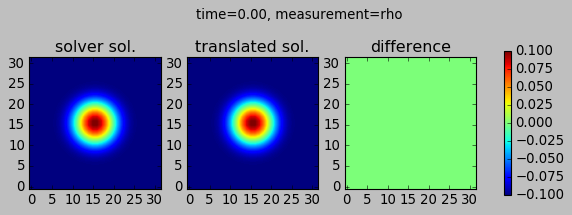

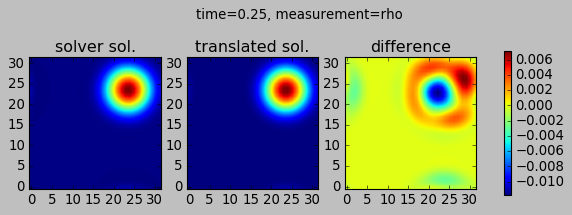

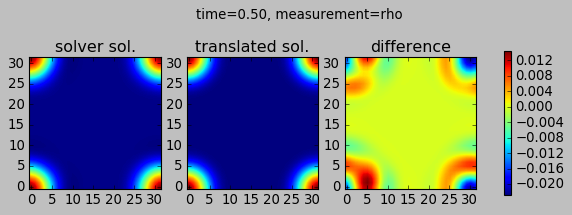

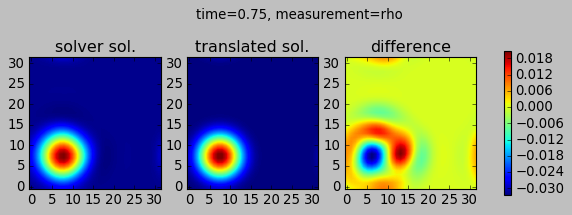

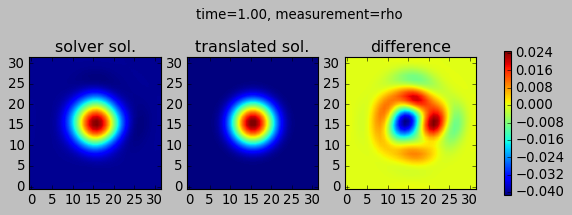

KeyError: "Unable to open object (object 'rho_ensemble_mem=0_1.25_after_full_step' doesn't exist)"

In [166]:
print_output = True

attribute = 'rho'
time = 0.00
comp_ref_0 = ensemble_test_case(time, py_path_ref_1,ref_size, attribute)
time = 0.25
comp_ref_1 = ensemble_test_case(time, py_path_ref_1,ref_size, attribute)

size = 1
grid_x = 32
grid_y = 32
end_time = 10.0
# suffix = '_truth'
suffix = '__'

fn = get_filename(grid_x,grid_y,size,end_time,suffix)
print(fn)

path = get_path(fn)

file = h5py.File(path, 'a')
attributes = ['rho', 'rhou', 'rhov', 'rhoY', 'Y']
for attr in attributes:
    if not (attr in file):
        file.create_group(attr,track_order=True)
    
file.close()

def roller(arr,n):
    arr = np.roll(arr,n,axis=0)
    arr = np.roll(arr,n,axis=1)
    return arr

# times = np.linspace(0.0,10.0,101*2-1)
# print(times)
steps = np.arange(0,321,8)
times = steps / 32
print(times)
print(py_path_ref_1)

rolled_0 = comp_ref_0.copy()
rolled_1 = comp_ref_0.copy()

file = h5py.File(path, 'r+')
cnt = 0

# print(py_path_ref_1)
for n in steps:
    time = times[cnt]
    name = "ensemble_mem=%i_%.2f_%s" %(0,time,'after_full_step')
#     print(name)
    for attribute in attributes:
        comp_ref_0 = ensemble_test_case(0.00, py_path_ref_1,ref_size, attribute)
        rolled_0 = roller(comp_ref_0,n)
        rolled_0 = np.pad(rolled_0,2,mode='wrap')
        comp_ref_1 = ensemble_test_case(time, py_path_ref_1,ref_size, attribute)
        file.create_dataset("%s/%s_%s" %(attribute,attribute,name), data=rolled_0, chunks=True, compression='gzip', compression_opts=4, dtype=np.float32)
    
    
# rolled = np.pad(rolled,2,mode='wrap')
        if print_output == True and attribute == 'rho':
            fig, ax = plt.subplots(ncols=3, figsize=(9,3))
            ax[0].imshow(comp_ref_1, origin='lower')
            ax[0].set_title("solver sol.")
            ax[1].imshow(rolled_0[2:-2,2:-2], origin='lower')
            ax[1].set_title("translated sol.")
            im2 = ax[2].imshow(comp_ref_1 - rolled_0[2:-2,2:-2], origin='lower')
            ax[2].set_title("difference")
#             fig.colorbar(im2,ax=ax[2],shrink=0.4)
            fig.colorbar(im2, ax=ax, shrink=.75)
            fig.suptitle("time=%.2f, measurement=%s" %(time,attribute))
            plt.savefig("../output_images/%s_%03d" %(attribute,cnt), bbox_inches='tight')
            plt.show()
    cnt += 1
    
file.close()

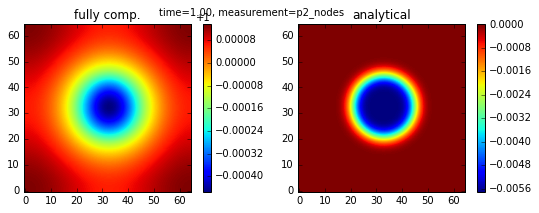

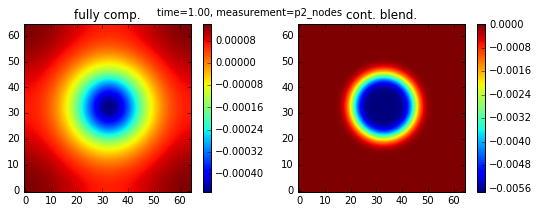

[0.         0.02941176 0.05882353 0.08823529 0.11764706 0.14705882
 0.17647059 0.20588235 0.23529412 0.26470588 0.29411765 0.32352941
 0.35294118 0.38235294 0.41176471 0.44117647 0.47058824 0.5
 0.52941176 0.55882353 0.58823529 0.61764706 0.64705882 0.67647059
 0.70588235 0.73529412 0.76470588 0.79411765 0.82352941 0.85294118
 0.88235294 0.91176471 0.94117647 0.97058824 1.        ]


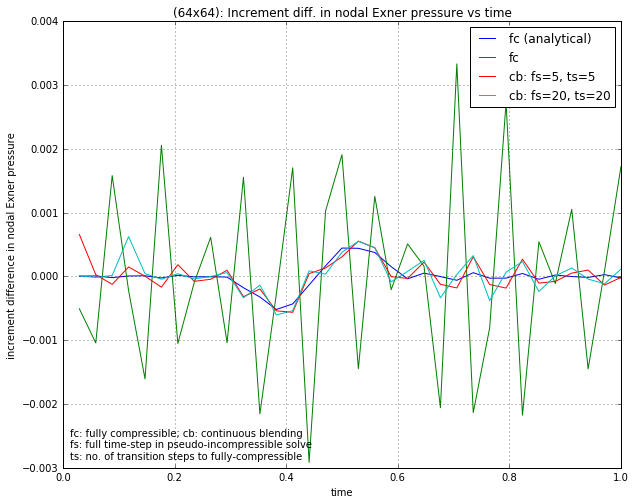

In [49]:
grid_x = 64
grid_y = 64
ens_size = 1
end_time = 1.0
attribute = 'p2_nodes'

time = 1.0
time = 1

def get_arr(time, suffix, cont_blend=False, ts=0, fs=0, end_time=end_time):
    if cont_blend == True:
        suffix += '_cont_blend_fs=%i_ts=%i' %(fs,ts)
        
    fn = get_filename(grid_x, grid_y, ens_size, end_time, suffix)
    path = get_path(fn)
    
    return ensemble_test_case(time, path, ens_size, attribute, label_type='STEP')

fc = get_arr(time, "_full_comp")
fc2 = get_arr(time, "_truth")

fig, ax = plt.subplots(ncols=2, figsize=(9,3))
im0 = ax[0].imshow(fc, origin='lower')
fig.colorbar(im0, ax=ax[0], shrink=1.0)
ax[0].set_title("fully comp.")
im1 = ax[1].imshow(fc2, origin='lower')
fig.colorbar(im1, ax=ax[1], shrink=1.0)
ax[1].set_title("analytical")
fig.suptitle("time=%.2f, measurement=%s" %(time,attribute))
plt.show()


time = 1.0
time = 1
attribute = 'p2_nodes'

cb2 = [0,0]
fc = get_arr(time,"",cont_blend=True,fs=cb2[0],ts=cb2[1])
fc2 = get_arr(time, "_truth")

fig, ax = plt.subplots(ncols=2, figsize=(9,3))
im0 = ax[0].imshow(fc, origin='lower')
fig.colorbar(im0, ax=ax[0], shrink=1.0)
ax[0].set_title("fully comp.")
im1 = ax[1].imshow(fc2, origin='lower')
fig.colorbar(im1, ax=ax[1], shrink=1.0)
ax[1].set_title("cont. blend.")
fig.suptitle("time=%.2f, measurement=%s \n\n" %(time,attribute))
plt.show()

# times = np.linspace(0,1.0,num=21)
times = np.arange(0,174,5)
times_axis = np.linspace(0,1.0,num=174/5+1)

print(times_axis)

def get_diff(probe):
    probe = np.array(probe)
    return probe[1:] - probe[:-1]

probe_row = 50
probe_col = 5
attribute = 'p2_nodes'
cb1 = [5,5]
cb2 = [20,20]

def get_time_series(times, suffix, cont_blend=False, ts=0, fs=0, end_time=end_time):
    probe = []
    for time in times:
        arr = get_arr(time, suffix, cont_blend, ts, fs, end_time=end_time)
        probe.append(arr[probe_row,probe_col])
    
    return get_diff(probe)
    
probe = get_time_series(times,"_truth")
probe_fc = get_time_series(times,"_full_comp")
probe_cb1 = get_time_series(times,"",cont_blend=True,fs=cb1[0],ts=cb1[1])
probe_cb2 = get_time_series(times,"",cont_blend=True,fs=cb2[0],ts=cb2[1])

fig1 = plt.figure(figsize=(10,8))
plt.plot(times_axis[1:],probe, label='fc (analytical)')
plt.plot(times_axis[1:],probe_fc, label='fc')
plt.plot(times_axis[1:],probe_cb1, label='cb: fs=%i, ts=%i' %(cb1[0],cb1[1]))
plt.plot(times_axis[1:],probe_cb2, label='cb: fs=%i, ts=%i' %(cb2[0],cb2[1]))
plt.ylabel('increment difference in nodal Exner pressure')
plt.xlabel('time')
plt.title("(64x64): Increment diff. in nodal Exner pressure vs time")
txt = '''
        fc: fully compressible; cb: continuous blending
        fs: full time-step in pseudo-incompressible solve
        ts: no. of transition steps to fully-compressible
        '''
fig1.text(.1,.12,txt)
plt.xlim([0,times_axis[-1]])
plt.legend()
plt.grid()
plt.show()